In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

def img_show(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure("Image") # 图像窗口名称
    plt.imshow(img_rgb)
    plt.axis('off') # 关掉坐标轴为 off
    plt.show()

color_dist = {'red': {'Lower': np.array([0, 60, 60]), 'Upper': np.array([6, 255, 255])},
              'gray': {'Lower': np.array([0, 0, 46]), 'Upper': np.array([180, 43, 220])},
              'yellow': {'Lower': np.array([26, 43, 46]), 'Upper': np.array([34, 255, 255])},          
              'blue': {'Lower': np.array([100, 80, 46]), 'Upper': np.array([124, 255, 255])},
              'green': {'Lower': np.array([35, 43, 35]), 'Upper': np.array([90, 255, 255])},
              'none': {'Lower': np.array([0, 0, 0]), 'Upper': np.array([255, 255, 255])},}

# 摄像头内参
mtx = np.array([[1.35635605e+03, 0.00000000e+00, 6.46212314e+02],
       [0.00000000e+00, 1.35578874e+03, 3.78009469e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

dist = np.array([[-2.52464877e-01, 1.92828476e-01, -6.55508668e-04, 2.48903668e-03, -7.45335496e-01]])

In [3]:
img = cv2.imread("./obj/obj (1).jpg")

dst = cv2.undistort(img, mtx, dist, None, mtx)

hsv_img = cv2.cvtColor(dst, cv2.COLOR_BGR2HSV)

inRange_hsv = cv2.inRange(hsv_img,
                            color_dist["green"]["Lower"], 
                            color_dist["green"]["Upper"]
                            )

edges = cv2.Canny(inRange_hsv,50,150,apertureSize = 3)

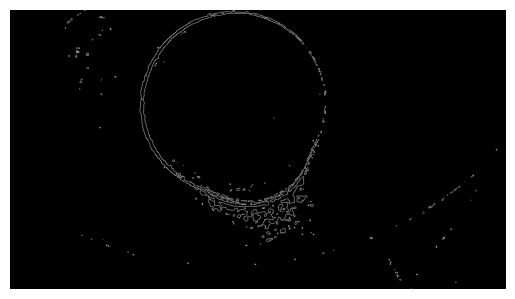

(720, 1280)
381.69877936737106 575.9774248589054


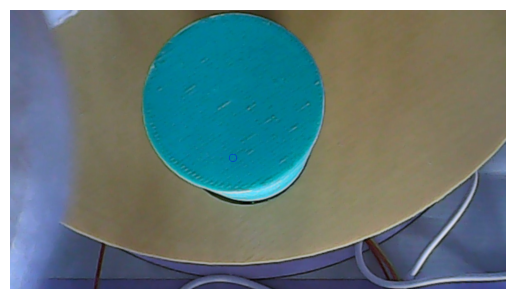

In [4]:
img_show(edges)
print(inRange_hsv.shape)

x_arg = 0.0
y_arg = 0.0
cnt = 0.0
# 行row 列col
for col in range(720):
    for row in range(1280):
        if inRange_hsv[col][row] != 0:
            x_arg += col
            y_arg += row
            cnt += 1

print(x_arg/cnt,y_arg/cnt)
img_show(cv2.circle(dst,(int(y_arg/cnt), int(x_arg/cnt)),10,(255,0,0)))



In [ ]:
from queue import PriorityQueue

def analy_line(x1,y1,x2,y2):
    assert(x1 != x2)
    x1 *= 1.0
    y1 *= 1.0
    x2 *= 1.0
    y2 *= 1.0
    k = (y2 - y1)/(x2 - x1)
    b = y1 - (k * x1)
    return k, b

def vertical_distance_point(analy,coord,dis):
    # 最大窗口限制
    max_x = 640
    min_x = 0
    max_y = 480
    min_y = 0
    if analy[0] != 0.0:
    # dis为正,返回在analy(x)右方距离点
        vert_k = -(1.0/analy[0])
        vert_b = coord[1] - (vert_k * coord[0])
        res_x = coord[0] + (dis * 1.0) / (math.sqrt(1.0 + vert_k * vert_k))
        if res_x > max_x:
            res_x = max_x - 1
        elif res_x < min_x:
            res_x = min_x + 1
        res_y = vert_k * res_x + vert_b
        if res_y > max_y:
            res_y = max_y - 1
            res_x = (res_y - vert_b) * 1.0 / vert_k
        elif res_y < min_y:
            res_y = min_y + 1
            res_x = (res_y - vert_b) * 1.0 / vert_k
        return (int(res_x), int(res_y))
    else:
    # dis为正,返回在analy(x)下方距离点
        res_x = coord[0]
        res_y = coord[0] + dis
        if res_y > max_y:
            res_y = max_y - 1
        elif res_y < min_y:
            res_y = min_y + 1
        return (int(res_x), int(res_y))

def fit_hsv_color(img_hsv, coord_1, coord_2, color, sampling_num = 10, assert_num = 0.6):
    # sampling_num: 两点间采样数 ； assert_num: 判断阈值，0.6表示有，60%的采样点符合即返回True
    if coord_1[0] > coord_2[0]:
        swap(coord_1,coord_2)
    sample_interval = (coord_2[0] - coord_1[0]) // sampling_num
    k,b = analy_line(coord_1[0], coord_1[1], coord_2[0], coord_2[1])
    true_num = 0
    for i in range(sampling_num):
        coord = []
        coord.append(coord_1[0] + i * sample_interval)
        coord.append(k * coord[0] + b)
        
        pix = img_hsv[int(coord[1]),int(coord[0])]
        color_flag = True
        for i in range(3):
            if (pix[i] < color_dist[color]["Lower"][i] 
                or pix[i] > color_dist[color]["Upper"][i]):
                color_flag = False
        true_num += int(color_flag)
    if (true_num * 1.0)/(sampling_num * 1.0) >= assert_num:
        return True
    else:
        return False

def line_len(x1,y1,x2,y2):
    x_dis = abs(x2 - x1)
    x_dis *= 1.0
    y_dis = abs(y2 - y1)
    y_dis *= 1.0
    lenth = math.sqrt(math.pow(x_dis,2)+math.pow(y_dis,2))
    return lenth
    
# 识别巡航边界
def cruising_boundary(img,upcolor,downcolor):
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_edges = cv2.Canny(img_gray,50,150,apertureSize = 3)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # 获取线条
    lines = cv2.HoughLinesP(img_edges,1,np.pi/180,100,minLineLength=100,maxLineGap=10)
    sort_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # 计算直线解析式 (y = k*x + b)
        if x1 != x2:
            k, b = analy_line(x1, y1, x2, y2)
        else:
            continue
        # 根据解析式筛除(+-30度)
        k_abs = 1.0 / math.sqrt(3)
        if (k < -k_abs or k > k_abs):
            continue
        else:
            pass
        # 根据颜色筛除
        sampling_distance = 8
        
        up_coord_1 = vertical_distance_point((k,b), (x1,y1), sampling_distance)
        up_coord_2 = vertical_distance_point((k,b), (x2,y2), sampling_distance)

        if fit_hsv_color(img_hsv, up_coord_1, up_coord_2, upcolor):
            pass
        else:
            continue
        
        down_coord_1 = vertical_distance_point((k,b), (x1,y1), -sampling_distance)
        down_coord_2 = vertical_distance_point((k,b), (x2,y2), -sampling_distance)
        
        if fit_hsv_color(img_hsv, down_coord_1, down_coord_2, downcolor):
            pass
        else:
            continue
        
        sort_lines.append(line)
    # 扩展线条(k,b 值相近(< buffer)的线条合并成一条线)
    for line in sort_lines:
        # (todo)采用优先队列排序
        pass
    
    # 筛选线条(选出最长的线条,即最接近目标的线条)
    length_line_queue = PriorityQueue()
    for line in sort_lines:
        x1, y1, x2, y2 = line[0]
        k, b = analy_line(x1, y1, x2, y2)
        length_line_queue.put((-line_len(x1, y1, x2, y2),((x1+x2)//2,(y1+y2)//2),(k,b)))
    res_line = length_line_queue.get()
    res_coord = res_line[1]
    res_analy = res_line[2]
    # 返回边界线(x,y),(k,b)
    return res_coord,res_analy
    

In [ ]:
edge_coord,edge_analy = cruising_boundary(dst,'gray','blue')
print(edge_analy)
dst = cv2.circle(dst,edge_coord,10,(90, 255, 255))
print(edge_coord[1])


In [ ]:
img_show(dst)

In [ ]:
def test():
    return None

if test() == None:
    print("hello")

In [ ]:

# codeinfo, points, straight_qrcode = cv2.QRCodeDetector().detectAndDecode(dst)
# print(codeinfo)
# print(len(codeinfo))

In [ ]:

# hsv_img = cv2.cvtColor(dst, cv2.COLOR_BGR2HSV)

# inRange_hsv = cv2.inRange(hsv_img, color_dist['green']['Lower'], color_dist['green']['Upper'])

In [ ]:
# img_show(inRange_hsv)

In [ ]:
# circle = cv2.HoughCircles(inRange_hsv, cv2.HOUGH_GRADIENT, 1, 50,
#                          param1=100, param2=80, minRadius=60, maxRadius=200)

# print(type(circle))

In [ ]:
# # 将检测结果绘制在图像上
# for i in circle[0, :]:  # 遍历矩阵的每一行的数据
#     # 绘制圆形
#     cv2.circle(dst1, (int(i[0]), int(i[1])), int(i[2]), (255, 0, 0), 10)
#     # 绘制圆心
#     cv2.circle(dst1, (int(i[0]), int(i[1])), 10, (255, 0, 0), -1)

# img_show(dst1)

In [ ]:
# img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# ret,img_bin=cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
# img_dst = cv2.medianBlur(img_gray, 7)